In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch_harmonics as th
import spherical_inr as sph
from sklearn.preprocessing import MinMaxScaler

In [2]:
l_freq = 23
coeffs = np.random.randn(l_freq+1)

def create_composite_function(l_freq, coeffs):
    # Precompute harmonic functions weighted by coefficients
    components = []
    
    for m in range(-l_freq, l_freq + 1):
            coeff = coeffs[m]
            harmonic_func = sph.get_SH(m, l_freq)
            components.append(lambda theta, phi, c=coeff, f=harmonic_func: c * f(theta, phi))

    # Combine into a single function
    def composite_function(theta, phi):
        return sum(func(theta, phi) for func in components)

    return composite_function

f_target = create_composite_function(l_freq, coeffs)

In [3]:
### Coarse gird

L_coarse = 75
phi_coarse, theta_coarse, (nlon_coarse, nlat_coarse) = sph.sample_s2(L_coarse, sampling = "gl", torch_tensor = True)
sht_coarse = th.RealSHT(nlat=nlat_coarse, nlon=nlon_coarse, lmax=L_coarse, mmax=L_coarse, grid = "legendre-gauss")

X_coarse = torch.stack([theta_coarse.flatten(), phi_coarse.flatten()], axis=-1).float()
y_coarse = f_target(theta_coarse.flatten(), phi_coarse.flatten()).unsqueeze(1).float()

coeffs_coarse = sht_coarse(y_coarse.reshape(nlat_coarse, nlon_coarse)).numpy()

scaler = MinMaxScaler()
y_coarse = torch.tensor(scaler.fit_transform(y_coarse)).float()

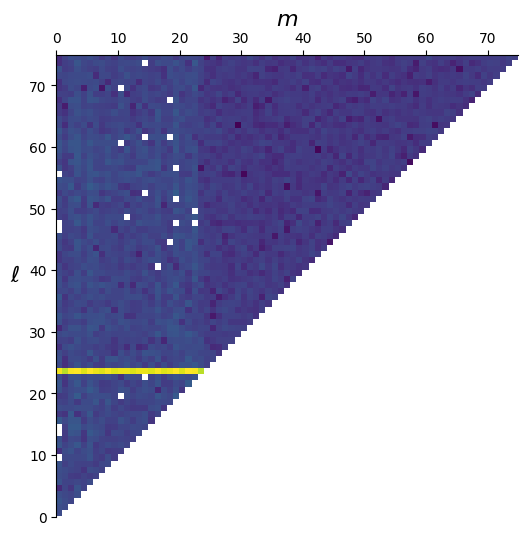

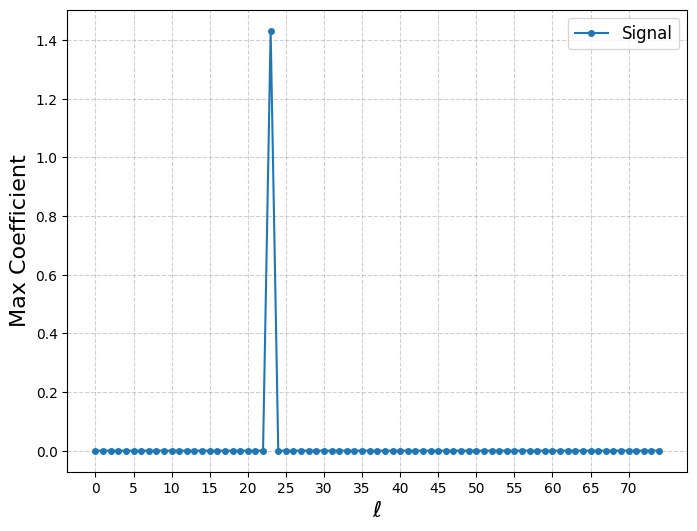

In [4]:
sph.plot_SHT_coeffs(coeffs_coarse)
sph.plot_max_SHT_coeffs(coeffs_coarse, ticks_l=5)
plt.show()

In [5]:
### Fine grid

L_fine = 150
phi_fine, theta_fine, (nlon_fine, nlat_fine) = sph.sample_s2(L_fine, sampling = "gl", torch_tensor = True)
sht_fine = th.RealSHT(nlat=nlat_fine, nlon=nlon_fine, lmax=L_fine, mmax=L_fine, grid = "legendre-gauss")

X_fine = torch.stack([theta_fine.flatten(), phi_fine.flatten()], dim=-1).float()
y_fine = f_target(theta_fine.flatten(), phi_fine.flatten()).unsqueeze(1).float()

coeffs_fine = sht_fine(y_fine.reshape(nlat_fine, nlon_fine)).numpy()

y_fine = torch.tensor(scaler.transform(y_fine)).float()

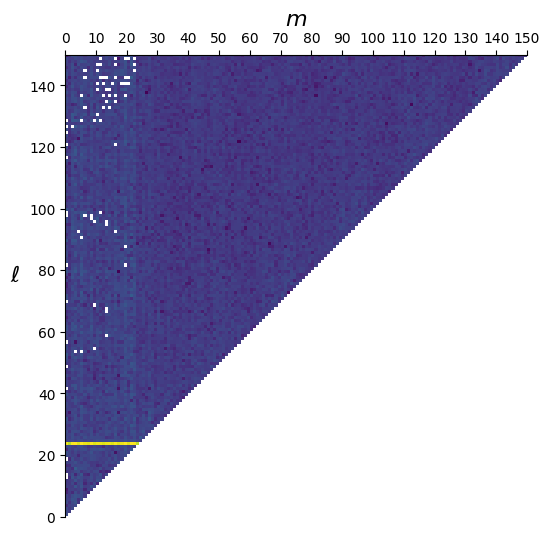

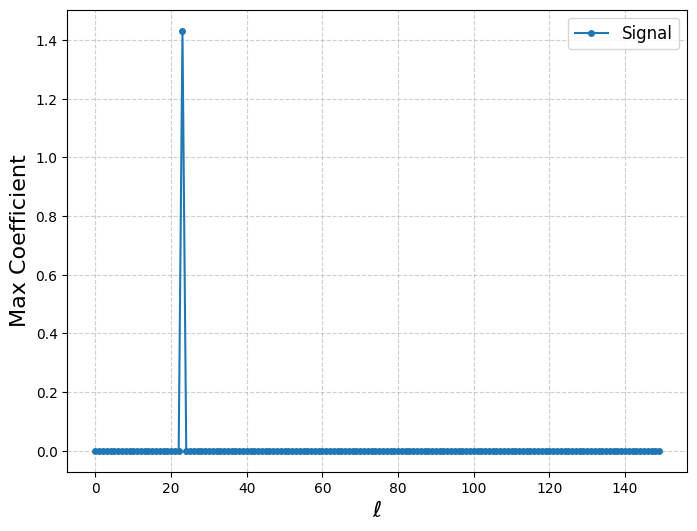

In [6]:
sph.plot_SHT_coeffs(coeffs_fine, ticks_l=20)
sph.plot_max_SHT_coeffs(coeffs_fine, ticks_l=20)
plt.show()

In [32]:
## Train SIREN for increasing alpha

activation_degrees = [(3, 5), (3, 10), (3, 50), (3, 100), (3, 100)]
alphas =  [(2, 3), (2, 3), (2, 3), (2, 3), (2, 3)]
dict_coeffs = {}

torch.manual_seed(42)
for (degree_first, degree_subseq), (alpha_first, alpha_subseq) in zip(activation_degrees, alphas):
    # theoretical expansion = 5 * alpha ** (2)

    sh_siren = sph.SphericalNet(
         L0 = 10, 
         Q = 3, 
         hidden_features = 50, 
         spectral_norm=True,
         bias = False, 
         activation = sph.Chebyshev(order = degree_subseq, alpha = alpha_first),
         first_activation = sph.Chebyshev(order = degree_first, alpha = alpha_subseq)
    )

    sph.train(
        x = X_coarse,
        y = y_coarse,
        model = sh_siren,
        loss_fn = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam(sh_siren.parameters(), lr=1e-3),
        epochs = 1000,
        batch_size = 512,
    )


    y_pred_fine = torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
    
    coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
    dict_coeffs[r"$\sigma_0(x) = T_{%.d}(x)$; $\sigma(x) = T_{%.d}(x) $"%(degree_first, degree_subseq)] = coeffs_pred_fine


In [33]:
sh_siren = sph.SphericalNet(
         L0 = 10, 
         Q = 3, 
         spectral_norm=False,
         hidden_features = 50, 
         activation =  torch.sin,
         first_activation = lambda x : torch.sin(5*x)
    )

sph.train(
    x = X_coarse,
    y = y_coarse,
    model = sh_siren,
    loss_fn = torch.nn.MSELoss(),
    optimizer = torch.optim.Adam(sh_siren.parameters(), lr=1e-3),
    epochs = 1000,
    batch_size = 1024,
)

y_pred_fine =  torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
dict_coeffs[r"$\sigma_0(x) = \sin(5x)$; $\sigma(x) = \sin(x) $"] = coeffs_pred_fine

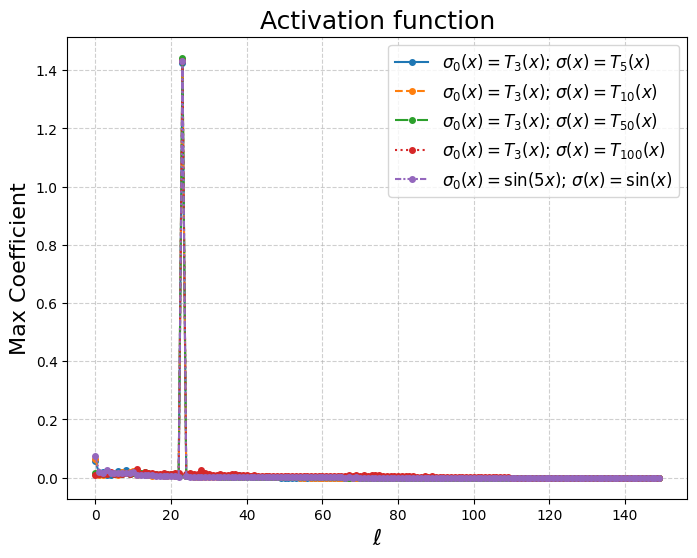

In [35]:
fig = sph.plot_max_SHT_coeffs(dict_coeffs, title="Activation function", ticks_l=20,)
# plt.yscale("log")
# plt.savefig("figures/aliasing_2.pdf")
plt.show()